# LDA2Vec
Adapted from tensorflow implementation: 

(Current) https://github.com/nateraw/Lda2vec-Tensorflow

(Old) https://github.com/meereeum/lda2vec-tf

(Original) https://github.com/cemoody/lda2vec

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis
import pickle

In [2]:
import sys
sys.path.append('./Lda2vec-Tensorflow-master')

In [3]:
from lda2vec import *

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1



## Find Ending Index of Documents for Each Year

In [5]:
data = pd.read_csv("papers.csv")

In [6]:
data = data.sort_values(by=["year"], kind='mergesort')

In [7]:
years = list(data["year"].unique())
counts = list(data["year"].value_counts())[::-1]
for i in range(1,len(counts)):
  counts[i] += counts[i-1]
year_index = {years[i]:counts[i] for i in range(len(years))}

In [8]:
year_index

{1987: 90,
 1988: 184,
 1989: 285,
 1990: 412,
 1991: 552,
 1992: 695,
 1993: 839,
 1994: 989,
 1995: 1139,
 1996: 1290,
 1997: 1442,
 1998: 1594,
 1999: 1746,
 2000: 1904,
 2001: 2101,
 2002: 2299,
 2003: 2503,
 2004: 2710,
 2005: 2917,
 2006: 3124,
 2007: 3341,
 2008: 3591,
 2009: 3853,
 2010: 4145,
 2011: 4451,
 2012: 4811,
 2013: 5179,
 2014: 5582,
 2015: 5993,
 2016: 6562,
 2017: 7241}

## Preprocessing

$\tt cleaned.txt$ is a txt file with all NIPS papers with all stop words and words with $\rm{length} \leq 3$ removed.

Preprocess incorporates tokenization (splitting sentences into words), creating a vocabulary to save mappings from tokens to integer indices, and generating skip-grams.

In [9]:
df = pd.read_csv("cleaned.txt")
df = df[df["stop_removed_paper_text"].notnull()]

In [10]:
df = df[4451:4551] # Use only 2011 papers

In [11]:
# Initialize a preprocessor
P = nlppipe.Preprocessor(df, "stop_removed_paper_text", max_features=30000, maxlen=10000, min_count=30)

/Users/keanl/miniforge3/lib/python3.9/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [12]:
# Run the preprocessing on your dataframe
P.preprocess()


---------- Tokenizing Texts ----------


100it [00:35,  2.80it/s]


Removing 12703 low frequency tokens out of 14216 total tokens

---------- Getting Skipgrams ----------


100it [00:02, 49.93it/s]


In [13]:
# Should we load pretrained embeddings from file
load_embeds = True

# Load embeddings from file if we choose to do so
if load_embeds:
    # Load embedding matrix from file path - change path to where you saved them
    embedding_matrix = P.load_glove("glove.6B.300d.txt")
else:
    embedding_matrix = None

/Users/keanl/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# Save data to data_dir
P.save_data("clean_data11", embedding_matrix=embedding_matrix)

## Using the LDA2Vec Model

Using the LDA2Vec model on preprocessed data.

In [5]:
# Path to preprocessed data
data_path  = "preprocess/paper_set_9"
# Whether or not to load saved embeddings file
load_embeds = True

# Load data from files
(idx_to_word, word_to_idx, freqs, pivot_ids,
 target_ids, doc_ids, embed_matrix) = utils.load_preprocessed_data(data_path, load_embed_matrix=load_embeds)

In [6]:
# Number of unique documents
num_docs = doc_ids.max() + 1
# Number of unique words in vocabulary (int)
vocab_size = len(freqs)
# Embed layer dimension size
# If not loading embeds, change 128 to whatever size you want.
embed_size = embed_matrix.shape[1] if load_embeds else 128
# Number of topics to cluster into
num_topics = 30
# Amount of iterations over entire dataset
num_epochs = 40
# Batch size - Increase/decrease depending on memory usage
batch_size = 4096
# Epoch that we want to "switch on" loss_lda
switch_loss_epoch = 0
# Pretrained embeddings value
pretrained_embeddings = embed_matrix if load_embeds else None
# If True, save logdir, otherwise don't
save_graph = False

In [7]:
# Initialize the model
m = model(num_docs,
          vocab_size,
          num_topics,
          embedding_size=embed_size,
          pretrained_embeddings=pretrained_embeddings,
          freqs=freqs,
          batch_size = batch_size,
          save_graph_def=save_graph)


EPOCH: 1
LOSS 30.558378 w2v 21.661829 lda 8.1744995 reg 0.72221166

EPOCH: 2
LOSS 13.25852 w2v 4.889975 lda 7.631418 reg 0.7371179

EPOCH: 3
LOSS 12.525526 w2v 4.6894903 lda 7.106733 reg 0.7292735

EPOCH: 4
LOSS 11.969208 w2v 4.641327 lda 6.612805 reg 0.7150346

EPOCH: 5
LOSS 11.417928 w2v 4.568045 lda 6.1557474 reg 0.6940718
Instructions for updating:
keep_dims is deprecated, use keepdims instead
---------Closest 10 words to given indexes----------
Topic 0 : etc, furthermore, importantly, smola, respectively, addition, biosift, instance, selecting, thresholding
Topic 1 : importantly, unfortunately, pseudo, furthermore, ldpc, smola, instance, dashed, glasso, suppose
Topic 2 : furthermore, unfortunately, smola, unlabeled, instance, importantly, dashed, marginals, suggests, etc
Topic 3 : importantly, furthermore, similarly, instance, estimating, unfortunately, fact, suggests, question, smoothness
Topic 4 : importantly, furthermore, ldpc, instance, marginals, outperforms, etc, respective

LOSS 8.406446 w2v 4.3907633 lda 3.831089 reg 0.18450734

EPOCH: 15
LOSS 8.113378 w2v 4.241401 lda 3.729271 reg 0.14258301
---------Closest 10 words to given indexes----------
Topic 0 : fujishige, norm, nominal, diag, wolfe, regularization, minimizer, anomaly, lasso, exploration
Topic 1 : lctw, warping, illustrated, corrlda, extends, canonical, subject, alignment, good, wolfe
Topic 2 : positions, arxiv, rkbs, self, epochs, intractable, deep, residual, rates, report
Topic 3 : predicting, actions, labelling, players, bandit, game, feedback, expected, combcascade, regret
Topic 4 : cascades, approximation, fractional, ratio, derivative, diffusion, reduces, fixed, applies, proportional
Topic 5 : pure, shift, span, filters, motion, phase, context, generative, dimensionality, field
Topic 6 : codebook, nystr, entries, correct, design, letters, column, eigenvectors, identical, epochs
Topic 7 : usual, blossom, modeled, inverse, recovered, covariance, kronecker, sparse, corresponds, true
Topic 8 :

LOSS 7.244852 w2v 3.8795824 lda 3.352845 reg 0.012421543

EPOCH: 27
LOSS 7.249992 w2v 3.893843 lda 3.3459978 reg 0.010141936

EPOCH: 28
LOSS 6.9578714 w2v 3.6091185 lda 3.3399816 reg 0.008760949

EPOCH: 29
LOSS 7.1651354 w2v 3.8225381 lda 3.3352025 reg 0.00740008

EPOCH: 30
LOSS 7.1097026 w2v 3.7721431 lda 3.330993 reg 0.006570613
---------Closest 10 words to given indexes----------
Topic 0 : quantity, norm, smallest, equivalently, interval, diag, parametric, xopt, aggregator, biosift
Topic 1 : lctw, illustrated, assignment, extends, subject, corrlda, subjects, know, events, warping
Topic 2 : <UNK>, residual, positions, effective, yahoo, self, report, confidence, epochs, cycles
Topic 3 : conditioning, returns, adversarial, agent, repeated, factors, makes, arms, learner, event
Topic 4 : ltsa, faster, derivative, exact, ratio, modified, naturally, fixed, technique, generating
Topic 5 : span, dimensionality, nonlinear, relation, invariant, filters, subspaces, subspace, ltsa, schnet
Topic 

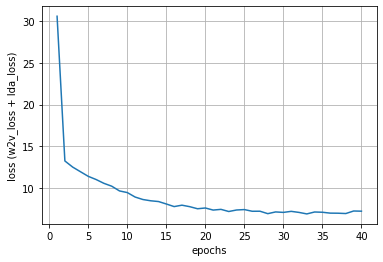

In [8]:
# Train the model
m.train(pivot_ids,
        target_ids,
        doc_ids,
        len(pivot_ids),
        num_epochs,
        idx_to_word=idx_to_word,
        switch_loss_epoch=switch_loss_epoch)

## Get Word and Topic Embeddings

Visualize topics

In [9]:
idx_to_word

{1: 'algorithm',
 2: 'data',
 3: 'model',
 4: 'learning',
 5: 'function',
 6: 'number',
 7: 'problem',
 8: 'matrix',
 9: 'time',
 10: 'method',
 11: 'given',
 12: 'results',
 13: 'random',
 14: 'methods',
 15: 'distribution',
 16: 'figure',
 17: 'models',
 18: 'algorithms',
 19: 'based',
 20: 'theorem',
 21: 'clustering',
 22: 'optimization',
 23: 'case',
 24: 'section',
 25: 'error',
 26: 'bound',
 27: 'probability',
 28: 'gradient',
 29: 'linear',
 30: 'following',
 31: 'analysis',
 32: 'different',
 33: 'large',
 34: 'information',
 35: 'convex',
 36: 'image',
 37: 'points',
 38: 'optimal',
 39: 'approach',
 40: 'graph',
 41: 'functions',
 42: 'performance',
 43: 'approximation',
 44: 'vector',
 45: 'convergence',
 46: 'pages',
 47: 'loss',
 48: 'point',
 49: 'machine',
 50: 'sample',
 51: 'training',
 52: 'example',
 53: 'note',
 54: 'size',
 55: 'parameter',
 56: 'work',
 57: 'rate',
 58: 'order',
 59: 'space',
 60: 'sparse',
 61: 'networks',
 62: 'value',
 63: 'kernel',
 64: 'var

In [10]:
doc_embed = m.sesh.run(m.mixture.doc_embedding)

In [11]:
topic_embed = m.sesh.run(m.mixture.topic_embedding)

In [12]:
word_embed = m.sesh.run(m.w_embed.embedding)

In [13]:
# Extract all unique words in order of index 0-vocab_size
vocabulary = []
for k,v in idx_to_word.items():
    vocabulary.append(v)

In [14]:
doc_lengths = np.load("preprocess/paper_set_0/doc_lengths.npy")

In [15]:
vis_data = utils.prepare_topics(doc_embed, topic_embed, word_embed, np.array(vocabulary), doc_lengths=doc_lengths,
                              term_frequency=freqs, normalize=True)

In [16]:
prepared_vis_data = pyLDAvis.prepare(**vis_data)

/Users/keanl/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/keanl/miniforge3/lib/python3.9/site-packages/pa

In [17]:
pyLDAvis.display(prepared_vis_data)

In [18]:
np.save("embeds/doc_embed_9", doc_embed)

In [19]:
np.save("embeds/word_embed_9", word_embed)

In [20]:
np.save("embeds/topic_embed_9", topic_embed)